## Imports

In [1]:
import netsquid as ns
from netsquid.components import T1T2NoiseModel,QuantumChannel, FibreDelayModel
from netsquid.components.instructions import *
from netsquid.components.qchannel import QuantumChannel
from netsquid.components.qprocessor import QuantumProcessor
from netsquid.components.qprocessor import *
from netsquid.components.qprogram import *
from netsquid.components.qsource import QSource, SourceStatus
from netsquid.nodes.node import Node
from netsquid.nodes.connections import DirectConnection
from netsquid.qubits.qformalism import QFormalism
from netsquid.qubits.state_sampler import StateSampler
from netsquid.qubits import ketstates as ks
from netsquid.qubits.state_sampler import StateSampler
from netsquid.util.simstats import *

import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

from n_node_RB import MultiNodeRB
from teleportationnoisemodel import TeleportationNoiseModel


## 2 node simulation

In [2]:
ns.sim_reset()
T1 = 10**9 
T2 = 12 * 10**6
gate_time = 39*10**(3)
alpha = 0.95
ns.set_qstate_formalism(QFormalism.DM)
n_nodes =2
nodes = [Node(f"{i}") for i in range(n_nodes)]
qchannelsUP ={i:QuantumChannel(f"TelChannel{i}{i+1}", length=40, models = {"delay_model":FibreDelayModel(),
                           "quantum_noise_model":TeleportationNoiseModel(alpha=alpha)}) for i in range(n_nodes)}
qchannelsDOWN ={i:QuantumChannel(f"TelChannel{i+1}{i}", length=40, models = {"delay_model":FibreDelayModel(),
              "quantum_noise_model":TeleportationNoiseModel(alpha=alpha)}) for i in range(n_nodes)}
qproc0 = QuantumProcessor("QPD-0", num_positions=2, mem_noise_models=[T1T2NoiseModel(T1=T1,T2=T2)]*2)
qprocs = {i:QuantumProcessor(f"QPD-{i}", num_positions=1, mem_noise_models=[T1T2NoiseModel(T1=T1,T2=T2)]) for i in range(1,n_nodes)}
nodes[0].qmemory = qproc0
for i in range(1, n_nodes):
    nodes[i].qmemory = qprocs[i]
state_sampler = StateSampler([ks.s0], probabilities=[1.0])
nodes[0].add_subcomponent(QSource("QSource", state_sampler=state_sampler, status=SourceStatus.EXTERNAL))
for i in range(n_nodes-1):
  nodes[i].connect_to(nodes[i+1],DirectConnection(f"quantum_connect{i}{i+1}",qchannelsUP[i],qchannelsDOWN[i]), label=f"quantum{i}{i+1}")
min_bounces = 2
max_bounces= 20
two_node_RB = MultiNodeRB(nodes=nodes, min_bounces=min_bounces, max_bounces=max_bounces, n_samples=40)
for instr in two_node_RB.cliffords:
    nodes[0].qmemory.add_instruction(instr, duration=gate_time, topology=[0], q_noise_model=T1T2NoiseModel(T1=T1, T2=T2))
    for i in range(1, n_nodes):
        nodes[i].qmemory.add_instruction(instr, duration=gate_time, topology=[0], q_noise_model=T1T2NoiseModel(T1=T1, T2=T2))
two_node_RB.start()        
ns.sim_run()
mean_fids, all_seq_fids = two_node_RB.get_fidelity()
with open("AB_decay.pickle", "wb") as f:
    pk.dump({"decay data": (mean_fids, all_seq_fids), "endpoints":  [min_bounces, max_bounces]}, f)

## Plotting

/tmp/ipykernel_22374/1486738630.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  g.show()


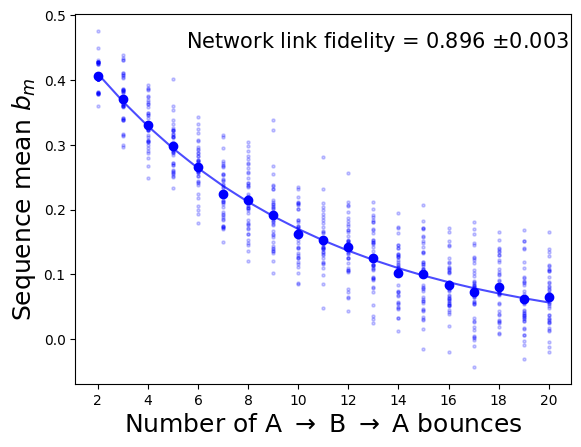

In [3]:
def exp(m,A,f):
	return A* f**m
plt.close()
with open('AB_decay.pickle', 'rb') as f:
	fid_AB = pk.load(f)
	endpoints_AB = fid_AB["endpoints"]
	fid_AB_means = fid_AB["decay data"][0] 
	fid_AB_data = fid_AB["decay data"][1]
popt_AB,pcov_AB = curve_fit(exp,np.array(range(endpoints_AB[0],endpoints_AB[1]+1)), [fid_AB_means[i] for i in range(endpoints_AB[0],endpoints_AB[1]+1)])
h = t.ppf((1 +0.95) / 2., 18-2)
g = plt.figure(2)
ax2 = plt.subplot()
ax2.scatter(range(endpoints_AB[0],endpoints_AB[1]+1), [fid_AB_means[i] for i in range(endpoints_AB[0],endpoints_AB[1]+1)],color = "b",label = r"$\alpha =0.97$")
for k in range(len(fid_AB_data[endpoints_AB[0]])):
		ax2.scatter(range(endpoints_AB[0],endpoints_AB[1]+1), [fid_AB_data[i][k] for i in range(endpoints_AB[0],endpoints_AB[1]+1)],color = "b",alpha = 0.2,s=5)
ab_fid  = f"Network link fidelity = {popt_AB[1]:.3f}" f" $\\pm${h*np.sqrt(pcov_AB[1,1]):.3f}"
ax2.text(5.5,0.45,ab_fid,fontsize = 15)
ax2.plot(range(endpoints_AB[0],endpoints_AB[1]+1), [exp(m, popt_AB[0],popt_AB[1]) for m in range(endpoints_AB[0],endpoints_AB[1]+1)] ,color = "b",alpha = 0.7)
ax2.set_xlabel("Number of A $\\to$ B $\\to$ A bounces",fontsize =18)
ax2.set_ylabel("Sequence mean $b_m$",fontsize =18)
ax2.set_xticks(np.arange(2,21,2))
g.savefig("two_node_netrb",transparent=True)
g.show()
plt.show()